In [8]:
import path
import libs.checker as checker
from control import *
from z3 import *
from scipy.signal import lti, step, impulse
import scipy.signal as sig
from matplotlib import pyplot as p

This example is borrowed and adapted from [1], advanced problem 5.6 on Pg. 358. Given a feedback closed-loop system, who transfer function is computed by:
$$ H(s) = \frac{K K_m}{s^2 + (K_m K_b+0.01) s + K K_m}$$

select $K, K_b$ and $K_m$ so that steady-state error is equal to 1 to a ramp input.

[1] Richard C.. Dorf, and Robert H. Bishop. Modern control systems. Pearson Prentice Hall, 2016. Pg. 359

It is interesting in this case that we cannot directly apply final value theorem as the system does not have a steady state to a ramp input. However, the error is converging. Thus, we can apply final value theorem on the steady state error: 

$$e_{ss} = \lim_{s=0} s E(s) = \lim_{s=0} s(1-H(s)) R(s) = \frac{K_m K_b + 0.01}{K K_m} = 1$$ 

In [9]:
# Constants

Km = Real('Km')
Kb = Real('Kb')
K = Real('K')
omega = Real('omega')
zeta = Real('zeta')

# Setup
f1 = omega * omega == K * Km
f2 = Km*Kb+0.01 == 2 * zeta * omega
safety = (Km*Kb+0.01) / (K * Km) == 1

f3 = And(f1,f2,safety) # we want solve satisfication problem instead of validity problem here

c = checker.Checker(zeta,omega)
c.add(f3)



In [10]:
# result
c.result()

static checking result =  sat
static checking model =  [zeta = 0.0625,
 Km = 0.5,
 omega = 0.125,
 Kb = 0.01125,
 K = 0.03125,
 /0 = [(0.015625, 0.015625) -> 1, else -> 0]]


In [11]:
# model extraction

v_Km = c.model(Km)
v_Kb = c.model(Kb)
v_K = c.model(K)


In [12]:
# transfer function construction

# generate a time span of 1000 sec, with step of 0.1
import numpy as np
tspan = np.arange(0, 1000, 0.1).tolist()

# sys to ramp ref

a = v_K*v_Km
b = v_Km*v_Kb+0.01

Hs_num = [a]
Hs_den = [1, b, a, 0, 0]
Hs = lti(Hs_num, Hs_den)
t, s = impulse(Hs, T=tspan)

# ramp ref

ramp_num = [1]
ramp_den = [1, 0, 0]
ramp = lti(ramp_num, ramp_den)
t2, s2 = impulse(ramp, T=tspan)

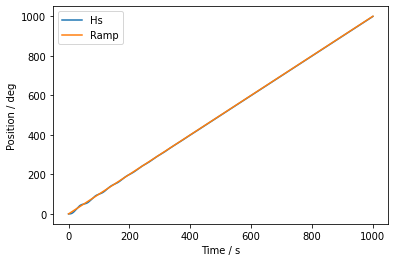

In [13]:
# plot

p.plot(t, s, label='Hs')
p.plot(t2,s2, label='Ramp')
p.xlabel('Time / s')
p.ylabel('Position / deg')
p.legend()
p.show()

As we can see from the plot, the system tracking the ramp input. We can also compute that its steady state error is about 1 towards time infinity:

In [14]:
# steady state error

e = np.subtract(s,s2)[-10:]
print(e)

[-0.99700574 -0.99702466 -0.99704402 -0.99706381 -0.99708402 -0.99710466
 -0.99712572 -0.9971472  -0.99716908 -0.99719138]


In summary, we use time-domain metrics estimations to represent a hybrid system design as a satifiable problem to aid its design process. This enrich the applicability of our approach.